In [2]:

np.random.seed(10815657)


In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import math
import sklearn
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.neighbors import KernelDensity
from random import sample
from operator import itemgetter
from statsmodels.nonparametric.kernel_regression import KernelReg as NPKR
from scipy.interpolate import UnivariateSpline

plt.rc("font", size=15)


pylab.rcParams['figure.figsize'] = 5, 5


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

# Python implementation of the doubly robust estimator for a continuous intervention effect (Edward H. ,2017)

**Disclaimer : I translated the R code into python. Still I don't see it to be doubly robust... It is robust to intervention dependency mispecifications but not target mispecification... Also it is biased. The code will print many graphs and report that will help you take a decision rather or not trust the effect calculated. The form of the estimate is the same as for the discrete treatment, and the way each part of the estimated effect curve are calculated seems very legit, so I don't get why it doesn't work as intended...**

We have $\pmb{Z}=(Y,A,\pmb{L})\in(\mathcal{Y}\times\mathcal{A}\times\mathcal{L})$, where $Y$ is your target, $A$ a continuous treatment or exposure or intervention and $\pmb{L}$ some covariates.

This intervention effect estimator is found by regressing on $A$ the following function : 

$$\xi(\pmb{Z},\pi,\mu)=\frac{Y-\mu(\pmb{L},A)}{\pi(A|\pmb{L})}\int_{\mathcal{L}} \pi(A|\pmb{l}) \,d\mathbb{P}_n(\pmb{l}) + \int_{\mathcal{L}} \mu(A,\pmb{l}) \,d\mathbb{P}_n(\pmb{l}) $$

Where now :

$$\mu(\pmb{l},a)=(Y|\pmb{L}=\pmb{l},A=a)$$

This is easy to interpret: it's the mean outcome given treatment and covariate. You can have an estimation of it simply (and by defintion) by fitting a glm where your target is $Y$ and your covariates $A,\pmb{L}$.

$$\pi(a|\pmb{l})$$

is also easy to interpret as it is the conditional treatment density given a realization of the covariates. Again estimating that bit is just fitting a glm, with target $A$ and covariates $\pmb{L}$ and deducing the density of $a|\pmb{l}$ from it.

> A cool thing is that it doesn't need to be a glm. You can estimate those functions with machine learning algorithms too, thus adding causal inference to your machine learning modeling.

The two integrals are just denoting the average of those 2 functions above at constant treatment value over all the space of covariates. We will estimate those averages by creating new data (a bunch of points having the same $a$ but different $\pmb{l}$, and that for many different $a$) and calulate the outputs of this functions thanks to our previous fit. Then we will average the calulated value that shared initially the same $a$ but different $\pmb{l}$.

Quickly :

given $Y$ and $\pmb{L},A$ we find $\hat{\mu}(\pmb{L},A)$

Then we create data and corresponding $\bar{Y}$:
(Imagine you add only 3 data points and decided to create only 2 new $a$ )

$(\pmb{l_1},a_{new1})\rightarrow\bar{Y}_{new1}$

$(\pmb{l_2},a_{new1})\rightarrow\bar{Y}_{new2}$

$(\pmb{l_3},a_{new1})\rightarrow\bar{Y}_{new3}$

$(\pmb{l_1},a_{new2})\rightarrow\bar{Y}_{new4}$

$(\pmb{l_2},a_{new2})\rightarrow\bar{Y}_{new5}$

$(\pmb{l_3},a_{new2})\rightarrow\bar{Y}_{new6}$

Then $\int_{\mathcal{L}} \hat{\mu}(a_{new1},\pmb{l}) \,d\mathbb{P}_n(\pmb{l})$ is $\frac{1}{3}\sum_{i=1}^3\bar{Y}_{newi}$ ($\int_{\mathcal{L}} \hat{\mu}(a_{new2},\pmb{l}) \,d\mathbb{P}_n(\pmb{l})$ is $\frac{1}{3}\sum_{i=4}^6\bar{Y}_{newi}$). You then do that for all the $a_{newi}$ and regress $\int_{\mathcal{L}} \hat{\mu}(a,\pmb{l}) \,d\mathbb{P}_n(\pmb{l})$ according to $a$ (I used spline fitting). When you have that you can calculate the integral with the $a$ that you have in your data.

Same goes for the $\pi$ integral.




In [86]:
def DRE_continuous_better3(df_,I,T,La,Lt,mu_family,pi_family,xi_family,stats_xi,size,kern_pi='gaussian',v_t='c'):
    """""""""
    Estimates the effect curve of a continuous treatment on a target
    
    Inputs:
    df_ : data as a dataframe
    I : intervention variable
    T : target variable
    La : covariables for fitting the intervention variable
    Lt : covariablesfor fitting the target. Intervention variable will be automatically added so don't provide it here
    mu_family : statsmodel family for glm fitting of mu
    pi_family : statsmodel family for glm fitting of pi
    xi_family : statsmodel family for glm fitting of xi
    stats_xi : scipy stats distribution for xi 
    kern_pi : type of kernel to use for Kernel density estimation of pi
    v_t : type of the covariable to use for the kernel regression of xi. in our case where I is continous I don't see
    why one would want to change that (except they want to use it for discrete case which works but is a bit unproper)
    size :  the number of new I you want for estimating the integrals
    
    Outputs:
    df : all the intermediary calculation in  a dataframe format
    model : the glm model of xi according to I
    results : the results of the non parametric Kernel regression
    """""""""
    
    
    formula_mu=''.join([T+'~'+I+'+']+['+'.join([l for l in Lt])])
    formula_pi=''.join([I+'~']+['+'.join([l for l in La])])
    print(formula_mu)
    print(formula_pi)
    #This part just create a new set of data with the new I
    df=df_.copy()
    a_vals=np.linspace(df[I].min(),df[I].max(),size)#create new a
    n=len(df)
    
    df_bis2=pd.DataFrame()
    for v in list(set(Lt+La)):
        temp=[]
        df_bis2[v]=pd.concat([df[v] for f in range(size)],ignore_index=True)
        
    temp=[]
    for v in a_vals:
        temp+=[v for p in range(n)]
    df_bis2[I]=temp
    
    df_bis=pd.concat([df,df_bis2],ignore_index=True)
    #fit I
    pimod=smf.glm(formula=formula_pi,family=pi_family,data=df).fit()
    pimod_vals=pimod.predict(df_bis)
    print(pimod.summary())
    print()
    print()
    print()
    df_bis['pimod_vals']=pimod_vals
    df['pimod_vals']=pimod.predict(df)
    
    df_bis['sq']=(df_bis[I]-pimod_vals)**2
    df['sq']=(df[I]-df['pimod_vals'])**2
    fig = sm.qqplot((df['sq']-df['sq'].mean())/df['sq'].std(),stats.gamma,stats.t, fit=True, line="45")
    plt.title('QQ plot for sq and gamma distribution')
    plt.show()
    #fit normalize error to the estimated I. I don't understand why just not use the estimated I. But ok,
    # it's in the paper.
    pi2mod=smf.glm(formula='sq~'+'+'.join([l for l in La]),family=sm.families.Gamma(),data=df).fit()
    print(pi2mod.summary())
    print()
    print()
    print()
    pi2mod_vals=pi2mod.predict(df_bis)
    df['pi2mod_vals']=pi2mod.predict(df)
    df_bis['pi2mod_vals']=pi2mod_vals
    #estimating mu
    mumod=smf.glm(formula=formula_mu,family=mu_family,data=df).fit()
    print(mumod.summary())
    print()
    print()
    print()
    muhats_vals=mumod.predict(df_bis)
    df_bis['muhat_vals']=muhats_vals
    df['muhat_vals']=mumod.predict(df)
    
    df_bis['a_std']=(df_bis[I]-df_bis['pimod_vals'])/np.sqrt(df_bis['pi2mod_vals'])
    df['a_std']=(df[I]-df['pimod_vals'])/np.sqrt(df['pi2mod_vals'])
    #Get the density pi out of the I
    pi_val_shuffle=np.copy(df['a_std'])
    np.random.shuffle(pi_val_shuffle)
    dist_pi=sc.spatial.distance.pdist(pi_val_shuffle[:1000, np.newaxis])
    bw_pi=0.9*len(df['a_std'])**(-0.2)*np.std(dist_pi)
    varpi_kernel=KernelDensity(kernel=kern_pi,bandwidth=bw_pi).fit(pi_val_shuffle[:, np.newaxis])
    varpi_kernel_score2=np.exp(varpi_kernel.score_samples(df['a_std'][:, np.newaxis]))
    df['pihat_vals']=varpi_kernel_score2
    plt.plot(df['a_std'],varpi_kernel_score2,'k+')
    plt.xlabel(I+'_std|'+','.join(La))
    plt.ylabel('P('+I+'_std|'+','.join(La)+')=\n'+r'$\pi($'+I+'_std|'+','.join(La)+')')
    plt.show()
    #calculate the average of pi over the covariates for every specific new a
    temp=np.array(np.exp(varpi_kernel.score_samples(df_bis['a_std'].iloc[n:][:, np.newaxis])))
    temp2=temp.reshape(size,n)
    temp=np.mean(temp2,axis=1)
    great1=sorted([[p,u] for p,u in zip(a_vals, temp)],key=itemgetter(0))
    #univariate spline fitting of the value of the average according to new a
    spl_varpi = UnivariateSpline([v[0] for v in great1], [v[1] for v in great1],k=3)
    
    spl_varpi.set_smoothing_factor(0.1)
    #Using that fitting to interpolate the average given true a , not new created a
    df['varpi']=spl_varpi(df[I])
    plt.plot(df[I],df['varpi'],'k+')
    plt.ylabel(r'E['+'$\pi($'+I+'|'+','.join(La)+')'+']')
    plt.xlabel(r'$\pi($'+I+'|'+','.join(La)+')')
    plt.show()
    # same but for mu
    temp=np.array(df_bis['muhat_vals'].iloc[n:])
    temp2=temp.reshape(size,n)
    temp=np.mean(temp2,axis=1)
    great2=sorted([[p,u] for p,u in zip(a_vals, temp)],key=itemgetter(0))
    spl_varmu = UnivariateSpline([v[0] for v in great2], [v[1] for v in great2],k=3)
    
    spl_varmu.set_smoothing_factor(0.1)
    
    df['m']=spl_varmu(df[I])
    plt.plot(df[I],df['m'],'k+')
    plt.ylabel(r'E['+r'$\mu($'+I+','+','.join(Lt)+')'+']')
    plt.xlabel(r'$\mu$('+I+','+','.join(Lt)+')')
    plt.show()
    #calucate xi
    df['xi']=(df[T]-df['muhat_vals'])/(df['pihat_vals']/df['varpi'])+df['m']
    #a bunch of code to look at how we could describe those xi from a random variable point of view
    df_xi_shuffle=np.copy(df['xi'])
    np.random.shuffle(df_xi_shuffle)
    
    dist_epsi=sc.spatial.distance.pdist(df_xi_shuffle[:1000, np.newaxis])
    bw_epsi=0.9*len(df['xi'])**(-0.2)*np.std(dist_epsi)
    xi_kernel=KernelDensity(kernel='gaussian',bandwidth=bw_epsi).fit(df['xi'][:, np.newaxis])
    
    xi_val_plot=np.linspace(np.min(df['xi']),np.max(df['xi']),1000)
    
    xi_kernel_score_plot=xi_kernel.score_samples(xi_val_plot[:, np.newaxis])
    
    plt.hist(list(df['xi']),100,density=True,alpha=0.5)
    plt.plot(xi_val_plot,np.exp(xi_kernel_score_plot))
    plt.xlabel('xi')
    plt.ylabel('Density')
    plt.plot(df['xi'], -0.005 - 0.01 * np.random.random(df['xi'].shape[0]), '+k')
    plt.show()
    
    fig = sm.qqplot((df['xi']-df['xi'].mean())/df['xi'].std(),stats_xi,stats.t, fit=True, line="45")
    plt.title('QQ plot for xi and ' + str(xi_family).split('.')[-1].split(' ')[0])
    plt.show()
    
    #fitting xi according to I, using a glm that is adequate given the above check of the xi random variable type assumption
    model=smf.glm(formula='xi~'+I,family=xi_family,data=df).fit()
    print(model.summary())
    
    plt.plot(df[I],df['xi'],'rs',label='data')
    plt.plot(df[I],model.predict(df[I]),'k.',label='modeled')
    plt.ylabel('xi')
    plt.xlabel(I)
    plt.legend(loc='best')
    plt.title("GLM "+str(xi_family).split('.')[-1].split(' ')[0])
    plt.show()
    print()
    print()
    print()
    #Maybe you are not really happy with how you understand your xi and you don't want to make any assumptions : here
    #is a non parametric kernel regression
    model2=NPKR(df['xi'],df[I],var_type=v_t)
    print('Significance of '+I+' in the kernel fit of xi',model2.sig_test([0]))
    print('bw in NPKR',model2.bw)
    results=model2.fit()
    print('average slope in kernel regression', np.mean([v for v in results[1]]))
    plt.title('Kernel fit')
    plt.plot(df[I],df['xi'],'rs',label='data')
    plt.plot(df[I],results[0],'k.',label='modeled')
    plt.xlabel(I)
    plt.legend(loc='best')
    plt.ylabel('xi')
    plt.show()
    
    
    return df,model,results

In [31]:
import warnings
warnings.filterwarnings("ignore")

# Test : intervention normally distributed 

In [72]:
def simulate_dataset_c(n=100000):
    
    df = pd.DataFrame()
   
    df['C1'] = np.random.normal(0, 1, int(n))+1
    df['C2'] = np.random.normal(0, 1, int(n))+1
    df['A'] = 1*df['C1']+1*df['C2']+np.random.normal(0, 0.05, df.shape[0])
    
    df['error'] = np.random.normal(0, 0.05, df.shape[0]) 
    

    B0 = -1
    B1 = 3
    B2 = -3
    B3 = 3
    df['Y'] = B0 + (B1*df['A']) + (B2*df['C1']) + (B3*df['C2']) + df['error']
    
    print("The true outcome model is:")
    print('E[Y|A,C1,C2] = ' + str(B0) + ' + ' + str(B1) + '*A + ' + str(B2) + '*C1 + ' + str(B3) + '*C2')
    
    return(df)

In [73]:
df_original_c = simulate_dataset_c(n=100)

The true outcome model is:
E[Y|A,C1,C2] = -1 + 3*A + -3*C1 + 3*C2


Y~A+C1+C2
A~C1+C2
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      A   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                       0.0024115
Method:                          IRLS   Log-Likelihood:                 161.01
Date:                Tue, 16 Feb 2021   Deviance:                      0.23391
Time:                        16:37:45   Pearson chi2:                    0.234
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0085      0.008  

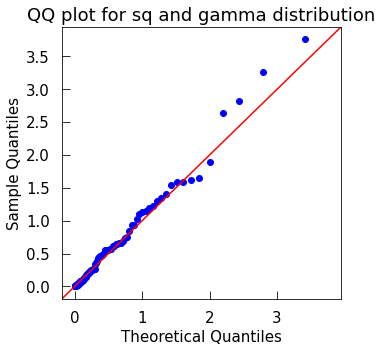

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     sq   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                   Gamma   Df Model:                            2
Link Function:          inverse_power   Scale:                          1.8510
Method:                          IRLS   Log-Likelihood:                 526.36
Date:                Tue, 16 Feb 2021   Deviance:                       246.91
Time:                        16:37:45   Pearson chi2:                     180.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    384.4136     89.052      4.317      0.0

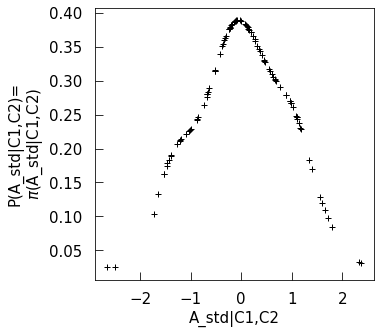

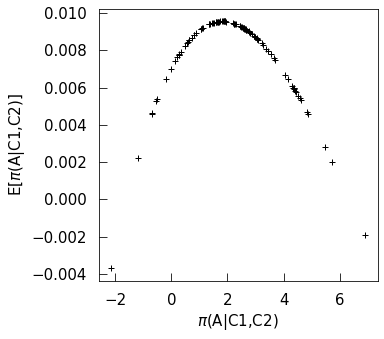

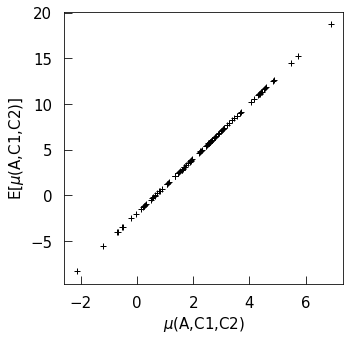

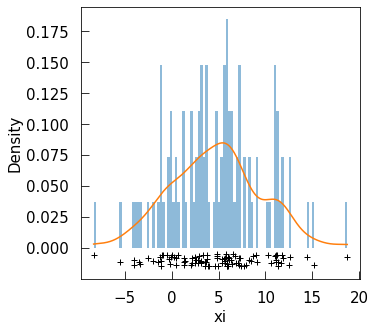

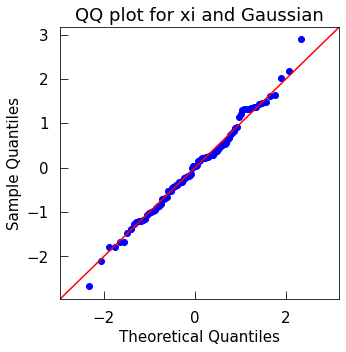

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     xi   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      1.0584e-05
Method:                          IRLS   Log-Likelihood:                 431.92
Date:                Tue, 16 Feb 2021   Deviance:                    0.0010373
Time:                        16:37:46   Pearson chi2:                  0.00104
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9222      0.001  -3500.118      0.0

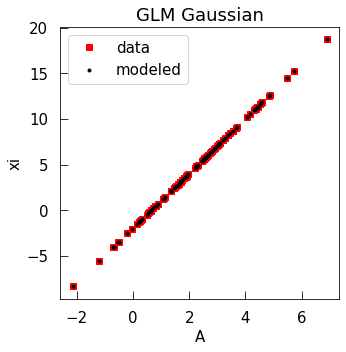




Significance of A in the kernel fit of xi ***
bw in NPKR [646693.24405851]
average slope in kernel regression 2.9974909989260787


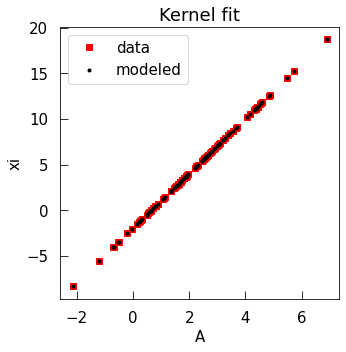

In [87]:
#When both model are well specified everything works well
df=df_original_c.copy()
dd=DRE_continuous_better3(df,'A','Y',['C1','C2'],['C1','C2'],sm.families.Gaussian(),sm.families.Gaussian(),sm.families.Gaussian(),stats.norm,100)

Y~A+C2
A~C1+C2
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      A   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                       0.0024115
Method:                          IRLS   Log-Likelihood:                 161.01
Date:                Tue, 16 Feb 2021   Deviance:                      0.23391
Time:                        16:37:48   Pearson chi2:                    0.234
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0085      0.008     

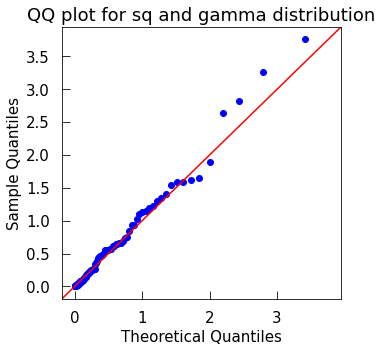

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     sq   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                   Gamma   Df Model:                            2
Link Function:          inverse_power   Scale:                          1.8510
Method:                          IRLS   Log-Likelihood:                 526.36
Date:                Tue, 16 Feb 2021   Deviance:                       246.91
Time:                        16:37:48   Pearson chi2:                     180.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    384.4136     89.052      4.317      0.0

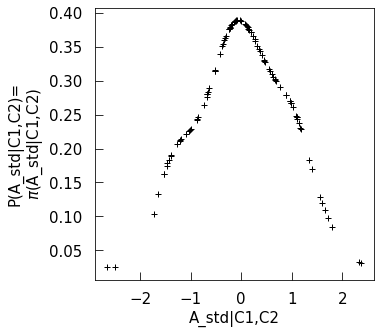

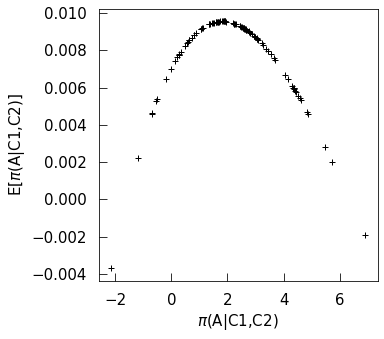

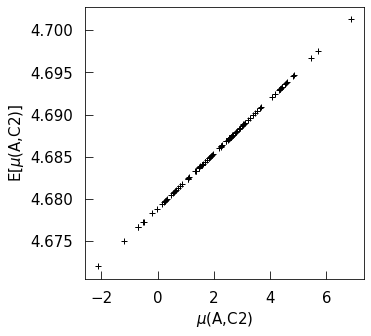

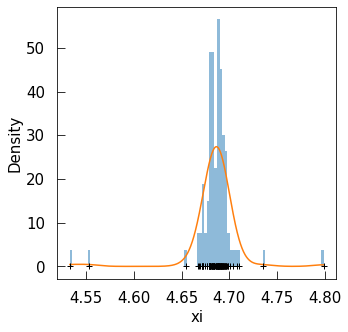

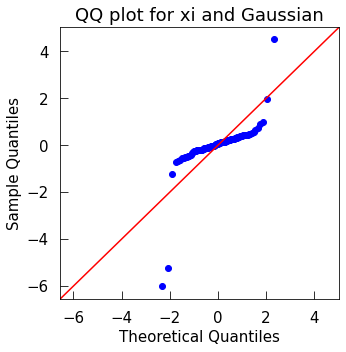

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     xi   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      0.00061793
Method:                          IRLS   Log-Likelihood:                 228.57
Date:                Tue, 16 Feb 2021   Deviance:                     0.060557
Time:                        16:37:49   Pearson chi2:                   0.0606
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6773      0.004   1114.662      0.0

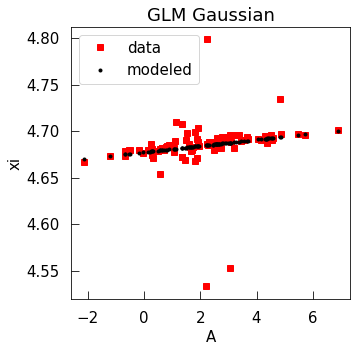




Significance of A in the kernel fit of xi **
bw in NPKR [2116027.22866088]
average slope in kernel regression 0.0033594237803526183


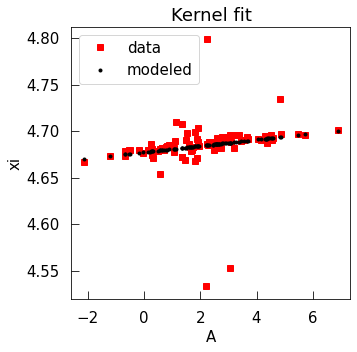

In [88]:
#When only the intervention model is well specified the DRE is doing poorly and not very much better than the regression
df=df_original_c.copy()
dd=DRE_continuous_better3(df,'A','Y',['C1','C2'],['C2'],sm.families.Gaussian(),sm.families.Gaussian(),sm.families.Gaussian(),stats.norm,100)

Y~A+C1+C2
A~C1
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      A   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.99494
Method:                          IRLS   Log-Likelihood:                -140.63
Date:                Tue, 16 Feb 2021   Deviance:                       97.504
Time:                        16:37:51   Pearson chi2:                     97.5
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7321      0.152     

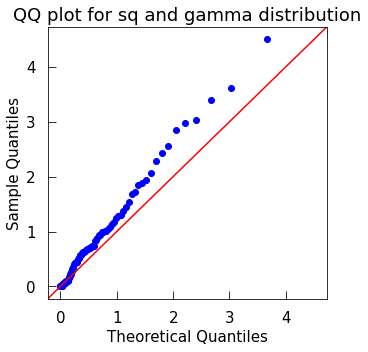

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     sq   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                   Gamma   Df Model:                            1
Link Function:          inverse_power   Scale:                          1.2703
Method:                          IRLS   Log-Likelihood:                -84.293
Date:                Tue, 16 Feb 2021   Deviance:                       235.29
Time:                        16:37:51   Pearson chi2:                     124.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3073      0.207      6.303      0.0

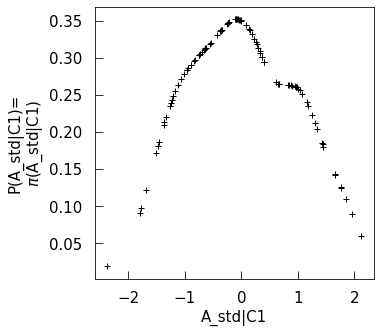

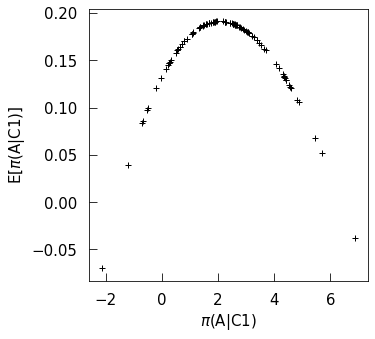

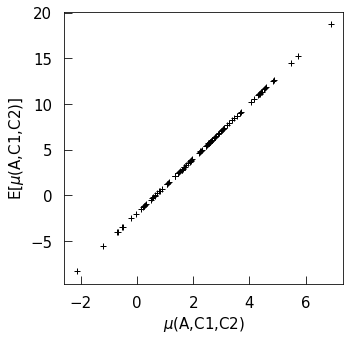

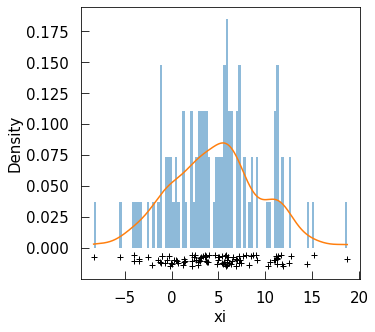

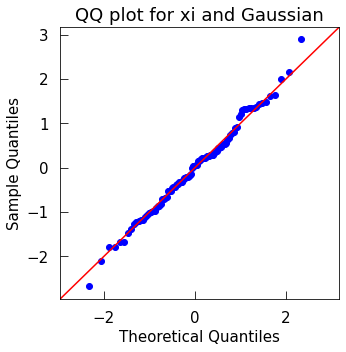

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     xi   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                       0.0034767
Method:                          IRLS   Log-Likelihood:                 142.20
Date:                Tue, 16 Feb 2021   Deviance:                      0.34071
Time:                        16:37:52   Pearson chi2:                    0.341
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9109      0.010   -191.991      0.0

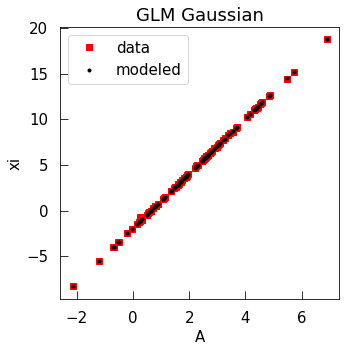




Significance of A in the kernel fit of xi ***
bw in NPKR [1185782.4954167]
average slope in kernel regression 2.9959594159882705


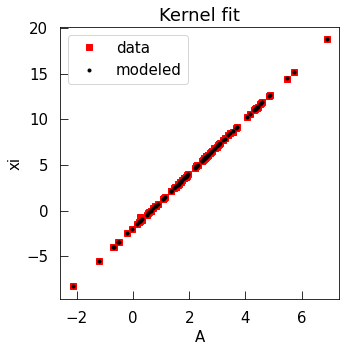

In [89]:
#When only the target model is well specified the DRE is doing good but not better than the regression
df=df_original_c.copy()
dd=DRE_continuous_better3(df,'A','Y',['C1'],['C1','C2'],sm.families.Gaussian(),sm.families.Gaussian(),sm.families.Gaussian(),stats.norm,100)

Even worst the DRE sees significant effect when there should not be... Or I am lost on what is a significant effect...

# Is the model robust to discrete intervention?

In [82]:
def simulate_dataset(n=100000):
    A_split = 0.4
    C1_split = 0.2
    C2_split = 0.65

    df_A1 = pd.DataFrame()
    df_A1['A'] = np.ones(int(n*A_split))
    df_A1['C1'] = np.random.uniform(0, 1, int(n*A_split))
    df_A1['C2'] = np.random.uniform(0, 1, int(n*A_split))
    df_A1.loc[df_A1['C1']<C1_split, 'C1'] = 0
    df_A1.loc[df_A1['C1']>=C1_split, 'C1'] = 1
    df_A1.loc[df_A1['C2']<C2_split, 'C2'] = 0
    df_A1.loc[df_A1['C2']>=C2_split, 'C2'] = 1

    df_A0 = pd.DataFrame()
    df_A0['A'] = np.zeros(int(n*(1-A_split)))
    df_A0['C1'] = np.random.uniform(0, 1, int(n*(1-A_split)))
    df_A0['C2'] = np.random.uniform(0, 1, int(n*(1-A_split)))
    df_A0.loc[df_A0['C1']<(1-C1_split), 'C1'] = 0
    df_A0.loc[df_A0['C1']>=(1-C1_split), 'C1'] = 1
    df_A0.loc[df_A0['C2']<(1-C2_split), 'C2'] = 0
    df_A0.loc[df_A0['C2']>=(1-C2_split), 'C2'] = 1

    df = pd.concat([df_A0, df_A1], axis=0).reset_index(drop=True)
    df['error'] = np.random.normal(0, 0.25, df.shape[0]) 
    del df_A1, df_A0

    B0 = -0.23
    B1 = 0
    B2 = 1.56
    B3 = 0.87
    df['Y'] = B0 + (B1*df['A']) + (B2*df['C1']) + (B3*df['C2']) + df['error']
    
    print("The true outcome model is:")
    print('E[Y|A,C1,C2] = ' + str(B0) + ' + ' + str(B1) + '*A + ' + str(B2) + '*C1 + ' + str(B3) + '*C2')
    
    return(df)

In [83]:
df_original_d = simulate_dataset(n=100)#100000

The true outcome model is:
E[Y|A,C1,C2] = -0.23 + 0*A + 1.56*C1 + 0.87*C2


Y~A+C1+C2
A~C1+C2
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      A   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57.802
Date:                Tue, 16 Feb 2021   Deviance:                       115.60
Time:                        13:52:15   Pearson chi2:                     102.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9283      0.398  

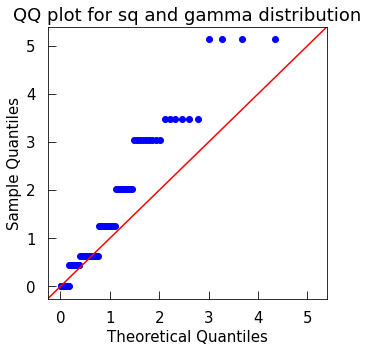

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     sq   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                   Gamma   Df Model:                            2
Link Function:          inverse_power   Scale:                          1.1955
Method:                          IRLS   Log-Likelihood:                 62.574
Date:                Tue, 16 Feb 2021   Deviance:                       104.94
Time:                        13:52:15   Pearson chi2:                     116.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9976      1.103      5.436      0.0

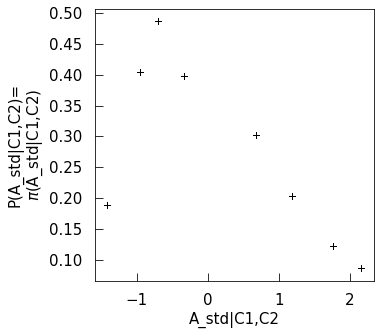

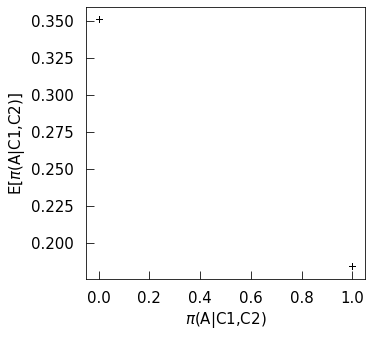

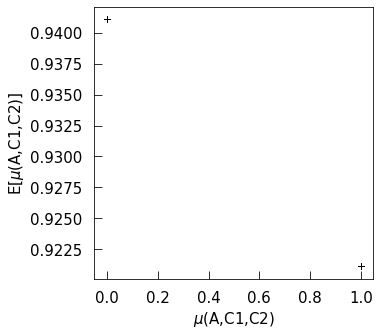

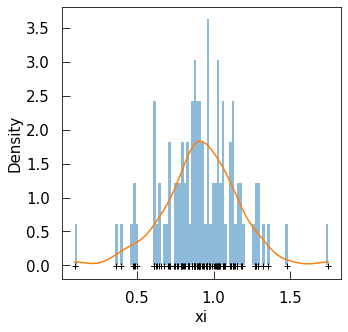

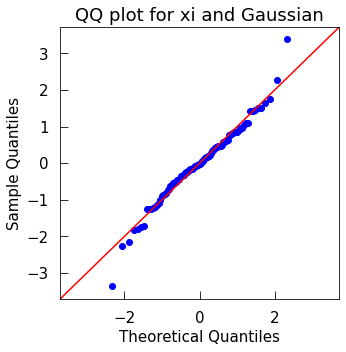

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     xi   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                        0.061338
Method:                          IRLS   Log-Likelihood:                -1.3160
Date:                Tue, 16 Feb 2021   Deviance:                       6.0111
Time:                        13:52:15   Pearson chi2:                     6.01
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9165      0.032     28.666      0.0

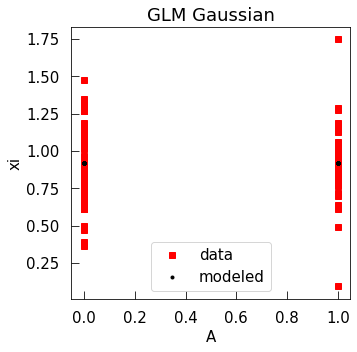




Significance of A in the kernel fit of xi Not Significant
bw in NPKR [0.1976892]
average slope in kernel regression 0.0045875176285211875


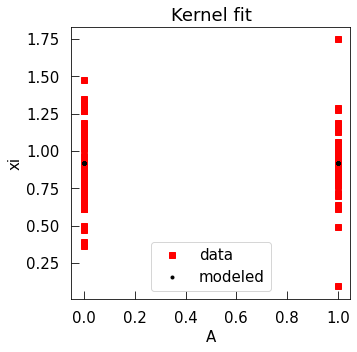

In [85]:

df=df_original_d.copy()
dd=DRE_continuous_better3(df,'A','Y',['C1','C2'],['C1','C2'],sm.families.Gaussian(),sm.families.Binomial(),sm.families.Gaussian(),stats.norm,100,'gaussian','u')